<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2025/Practica_8_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 8: Diagnóstico y selección de moelos

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov e inferencia variacional) problemas de inferencia estadística. En particular, vamos a proponer modelos de probabilidad condicionada con una única variable predictora, ya sea continua o discreta.

Para ello nos montaremos sobre dos librerías (paquetes de funciones)
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

## Librerías

En primer lugar, importamos o instalamos todas las librerías y funciones que utilizaremos a lo largo del Colab.

In [1]:
# importar librerias utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# graficos de residuos y qq-plots
import scipy
import statsmodels.api as sm

# librerias para abrir archivos
import io
from google.colab import files

# instalar bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.2 MB/s eta 0:00:00


## Funciones útiles (creadas por nosotros)

Para simplificar algunas dibujos, les dejamos aquí una serie de funciones escritas por nosotros para trabajar más facilmente con la salida de `Bambi` a la hora de analizar el ajuste de los datos y los residuos de modelos normales.

### Para QQ-Plots

In [2]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  return Qx, Qy

In [3]:
def plot_qqplot(inference_data,y,num_pp_samples,ax=None):
  # Graficar QQ-plot

  X = inference_data.posterior_predictive[y].values
  y = inference_data.observed_data[y].values

  # Plot
  if ax == None:
    fig, ax = plt.subplots(figsize=(5,5))

  # Post predictives
  for i in range(num_pp_samples):
    Qx, Qy = qqplot(np.ravel(X),np.reshape(np.ravel(X),(-1,len(y))).T[:,np.random.randint(0,len(np.reshape(np.ravel(X),(-1,len(y)))))])
    xmin = np.min([np.min(Qx),np.min(Qy)])
    xmax = np.max([np.max(Qx),np.max(Qy)])
    ax.plot( Qx, Qy, alpha=0.2, color='C0', linewidth=1.5)

  # Observed
  Qx, Qy = qqplot(np.ravel(X),y)
  xmin = np.min([np.min(Qx),np.min(Qy)])
  xmax = np.max([np.max(Qx),np.max(Qy)])
  ax.plot( Qx, Qy, color='k', linewidth=2)

  ax.plot([xmin,xmax],[xmin,xmax], color='C1', linestyle='--')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(xmin,xmax)
  ax.grid()
  ax.set_xlabel('Cuantiles Simulación')
  ax.set_ylabel('Cuantiles Muestras')
  #plt.show()

### Para residuos

In [62]:
def plot_residuos_1(dataframe,inference_data,y,num_pp_samples=np.nan,fig_size=(10,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  residuos = y_obs - mu_est.mean(axis=(0,1))
  if np.isnan(num_pp_samples):
    num_pp_samples = len(dataframe)

  fig, ax = plt.subplots(1,2,figsize=fig_size)
  for i in range(0,num_pp_samples):
    residuals = y_obs - mu_est[0,i,:]
    sns.kdeplot(residuals, ax=ax[0], linewidth=.3, alpha=.3, color='C0' )

  sns.kdeplot(residuos, ax=ax[0], linewidth=1., color='k' )
  ax[0].axvline(x=0, linestyle='--', color='gray', linewidth=1.5)
  ax[0].grid(True)
  ax[0].set_xlabel('residuos')
  ax[0].set_xlim(np.min(-np.abs(residuos))*1.5,np.max(np.abs(residuos))*1.5)

  scipy.stats.probplot(residuos,plot=ax[1])

  return fig, ax

In [75]:
def plot_residuos_2(dataframe,inference_data,y,x=None,hdi_prob=0.94,fig_size=(10,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  residuos = y_obs - mu_est.mean(axis=(0,1))
  #if x is not None:
  #  residuos = residuos[np.argsort(dataframe[x].values)]
  #else:
  #  residuos = residuos[np.argsort(y_obs)]

  # eje X
  if x is None:
    x_obs = mu_est.mean(axis=(0,1))
  else:
    x_obs = dataframe[x].values

  fig, ax = plt.subplots(1,2,figsize=fig_size)
  for i in range(len(dataframe)):
    residuals = y_obs[i] - mu_est.mean(axis=(0,1))[i]
    quantiles = az.hdi(np.ravel(y_obs[i]-mu_est[:,:,i]),hdi_prob=hdi_prob)
    ax[0].plot( [x_obs[i],x_obs[i]], quantiles, color='gray', alpha=.3 )
    ax[0].plot( x_obs[i], residuals.mean(), 'o', color='C0', markersize=2)
  ax[0].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
  ax[0].set_ylabel('residuo')
  if x is None:
    ax[0].set_xlabel(y)
  else:
    ax[0].set_xlabel(x)
  ax[0].grid(True)
  lim = np.max(np.abs(residuos))*1.5
  ax[0].set_ylim(-lim,lim)

  sm.graphics.tsa.plot_acf(residuos,ax[1])
  #if x is not None:
  #  ax[1].set_title('Autocorrelation - '+ ' ' + x)
  #else:
  #  ax[1].set_title('Autocorrelation - '+ ' ' + y)

  return fig, ax

## Ejemplo: Resistencia del hormigón como función de la relación agua-material cementicio

En este primer ejercicio, buscaremos responder la siguiente pregunta:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para eso, vamos a usar los datos de ensayos de probetas que tenemos disponibles y ajustar un modelo. Esta vez, vamos a enfocarnos en la evaluación de los modelos, y luego en la selección del "mejor modelo" para poder contestar la pregunta.

Contestar la pregunta en sí quedará para otra ocasión (lo tienen en la clase anterior).

### El dataset

Contamos con 103 muestras de hormigón ensayadas a los 28 días. Las mismas se extrajeron de un dataset público disponible en el repositorio de la Universidad de California Irvine. Pueden acceder al dataset haciendo click [aquí](https://archive.ics.uci.edu/dataset/182/concrete+slump+test).

Este dataset elaborado por I-Cheng Yeh ha sido utilizado en numerosas investigaciones.

In [7]:
# Subir archivo al colab
uploaded = files.upload()

Saving concrete_tests.xlsx to concrete_tests.xlsx


In [8]:
# Creamos el dataframe
df_horm = pd.read_excel(io.BytesIO(uploaded['concrete_tests.xlsx']))
df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0        62.0                               34.99  
1        20.0                               41.14  
2        20.0                               41.81  
3        21.5                               42.08  
4        64.0                               26.82  
..        ...                                 ...  
98       20.0                               49.97  
99       20.0                               50.23  
100      20.0                               50.50  
101      67.0                               49.17  
102      78.0                               48.77  

[103 rows x 10 columns]

Lo primero que vamos a hacer es, en forma rápida, crear una nueva columna de nombre `a_c` que represente la relación agua-material cementicio, que incluye el cemento, la escoria y las cenizas volantes.

También cambiaremos el nombre de la columna de resistencia para hacerlo más amigable.

In [9]:
# Construimos una variable a/c (relacion agua cemento)
df_horm['a_c'] = df_horm['Water']/(df_horm['Cement']+df_horm['Slag']+df_horm['Fly ash'])

# cambiamos el nombre de la resistencia a la compresion
df_horm.rename(columns={'Compressive Strength (28-day)(Mpa)': 'Resistencia_MPa'}, inplace=True)

df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Resistencia_MPa       a_c  
0        62.0            34.99  0.456522  
1        20.0            41.14  0.357853  
2        20.0            41.81  0.357285  
3        21.5            42.08  0.358000  
4        64.0            26.82  0.536585  
..        ...              ...       ...  
98       20.0            49.97  0.287050  
99       20.0            50.23  0.287146  
100      20.0            50.50  0.298943  
101      67.0            49.17  0.335698  
102      78.0            48.77  0.364574  

[103 rows x 11 columns]

Ya que queremos predecir la resistencia del hormigón para una determinada relación agua-cemento, veamos cómo interactuan estas dos variables entre sí en el dataset.

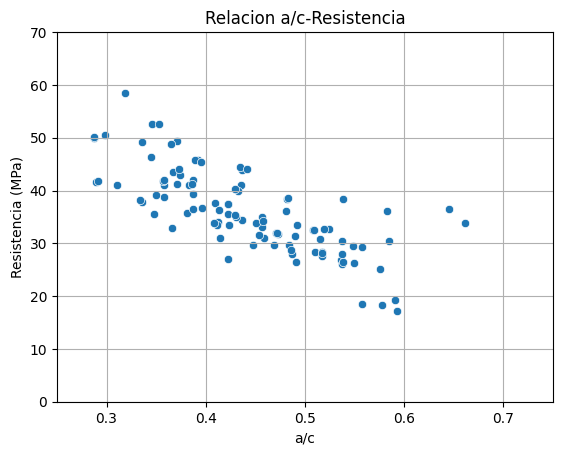

In [10]:
# graficamos la relacion a/c-Resistencia
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa')
plt.grid(True)
plt.xlabel('a/c')
plt.ylabel('Resistencia (MPa)')
plt.title('Relacion a/c-Resistencia')
plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Viendo el gráfico podrán notar dos cosas. Por un lado, no hay un sólo dato que tenga las relaciones agua-cemento que me interesan predecir. "No tengo los datos" para hacer un modelo de inferencia como veníamos trabajando hasta ahora (más allá de asumir que la `a/c` no importa y agrupar todo). Sin embargo, parece haber claramente una relación entre `a/c` y la resistencia ensayada de las probetas.

Por lo tanto, si pudiesemenos ajustar un modelo que determine cómo es esa relación entre `a/c` y la resistencia, podríamos luego usarlo para predecir datos nunca vistos como los pedidos al principio del problema.

### Modelo 1: Recta + error

El modelo más sencillo que podríamos plantear es una recta. Más formalmente, un modelo donde el valor medio es explicado por una recta a la que se le suma un término de error aleatorio.

$$y = A + B\cdot a/c + error$$

$$error \sim Normal(0,\sigma)$$

Otra forma de plantear esto mismo más genérica es como un modelo de probabilidad condicional. Es decir, la resistencia de la probeta dada la relación agua-cemento sigue una distribución normal cuyo valor medio depende de esta relación agua-cemento (en forma lineal).

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B \cdot a/c$$

Para nuestro proceso de inferencia, donde aplicaremos el teorema de bayes para definir la densidad de probabilidad posterior de los parámetros $A$, $B$, $\sigma$, necesitamos primer definir distribuciones a priori. Es decir, la probabilidad de que los parámetros tomen determinados valores *antes* de ver los datos.

Nosotros vamos a dejar que `Bambi` adopte distribuciones poco informativas por nosotros:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

#### Modelo

Cargar este modelo en `Bambi` es bastante sencillo, ya que el modelo normal (`family='gaussian'`) es el default del programa, y la ecuación para el valor medio (`link='identity'`) es el default para el modelo normal.

Por lo tanto, simplemente hay que indicar la columna del dataset que se quiere predecir (`Resistencia_MPa`) y las variables explicativas (`a_c`). `Bambi` automáticamente hace lo siguiente:

- Agrega una ordenada al origen o "Intercept" (lo que habíamos llamado $A$)
- Multiplica a la variable predictora por una constante con el mismo nombre. Es decir, llama $a\_c$ al parámetro que multiplica al predictor `a_c` del dataset (lo que habíamos llamado $B$)
- Genera el parámetro del desvío de la normal "sigma" ($\sigma$).

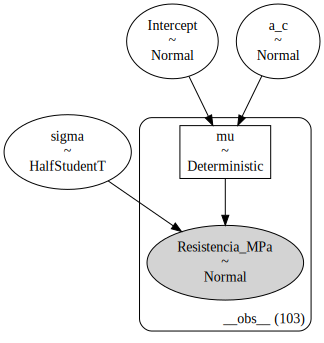

In [11]:
# creamos un modelo lineal (con error absoluto)
model_1 = bmb.Model('Resistencia_MPa ~ a_c', data=df_horm)
model_1.build()

# visualizacion
model_1.graph()

#### Prioris

Si bien arriba se puede ver en forma esquemática cómo funciona el modelo y las distribuciones a priori adotptadas, siempre es bueno visualizarlas para ver si están transmitiendo la información previa que nosotros queremos (o la no-información)

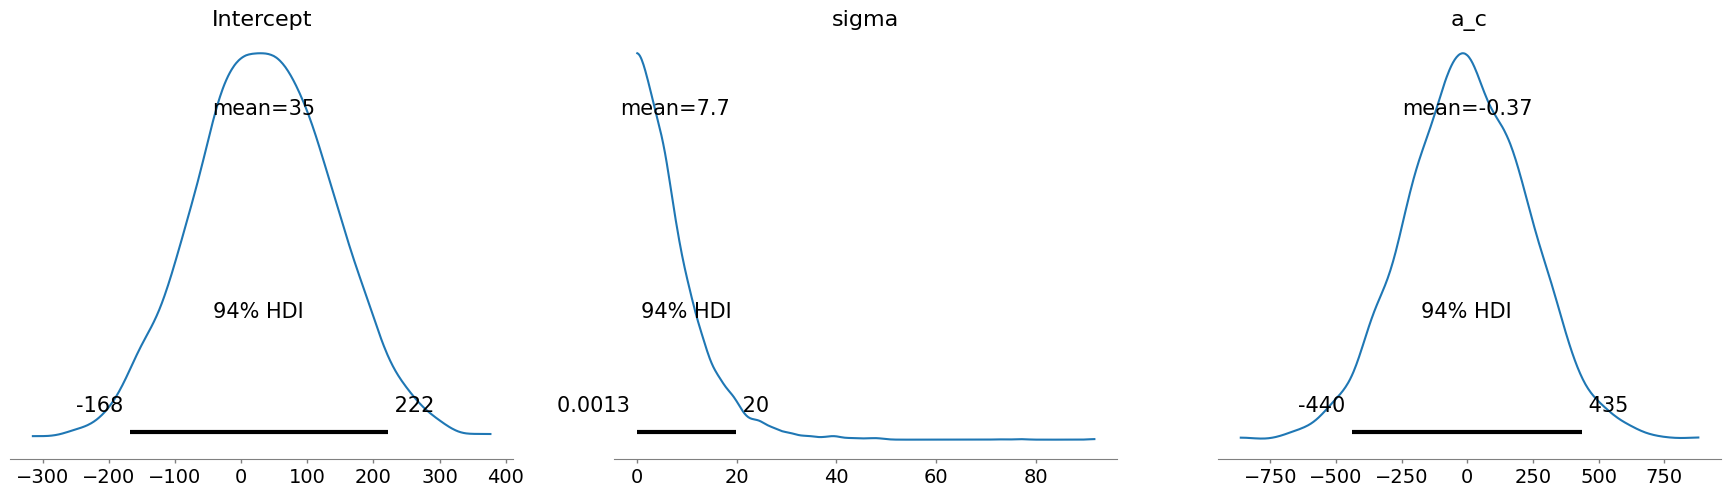

In [12]:
# ver distribuciones a priori
model_1.plot_priors()
plt.show()

#### Inferencia

Si ya tenemos nuestro modelo construido de acuerdo a nuestras necesidades, procedemos a hacer la inferencia. En este paso generaremos simulaciones de la distribución posterior de los parámetros ($Intercept$, $a\_c$, $sigma$) mediante cadenas de Markov. Estas se guardaran en mi variable `results_1`

Para asegurarnos que esté todo ok, revisamos que no haya divergencias durante el proceso, y que las cadenas hayan convergado tanto internamente como entre sí, pareciéndose a un ruido blanco.

Output()

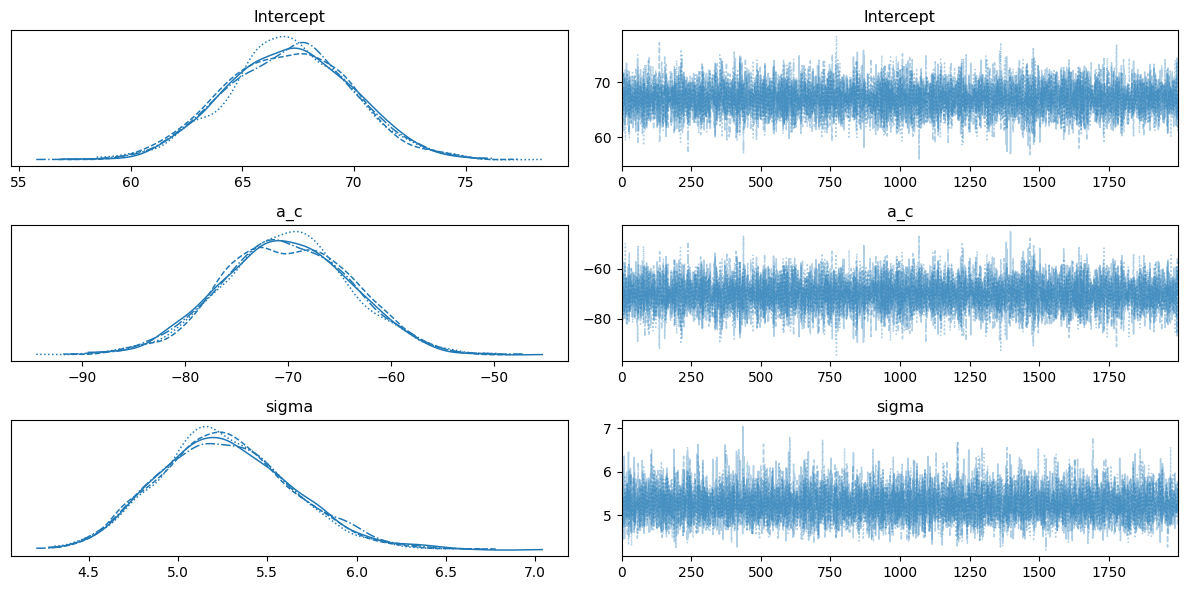

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  67.069  2.846  61.614   72.237      0.026    0.031   11724.0   
a_c       -70.164  6.292 -82.005  -58.643      0.057    0.069   12022.0   
sigma       5.265  0.375   4.579    5.960      0.004    0.004   10058.0   

           ess_tail  r_hat  
Intercept    6251.0    1.0  
a_c          6222.0    1.0  
sigma        5779.0    1.0

In [13]:
# Realizar la inferencia
results_1 = model_1.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_1)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_1)

¡En este caso todo parece andar bien!

#### Posterior

Si nuestra inferencia salió bien, ya podemos empezar a ver qué me dice. Por ejemplo, lo primero que puedo ver es cuánto valen los parámetros de mi modelo. Es decir, su distribución posterior (dado que tengo estos datos, ¿cuál es la probabilidad de que los parámetros valgan determinado valor?).

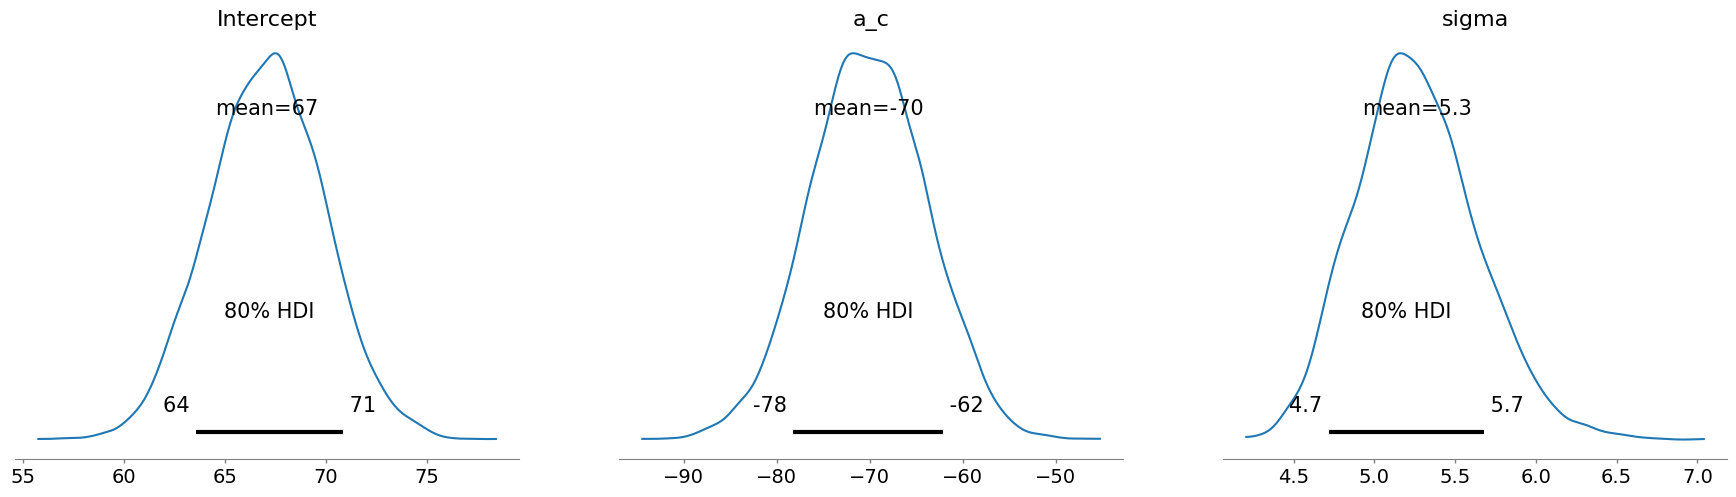

In [14]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_1,hdi_prob=0.8)
plt.show()

Es posible acceder manualmente a las simulaciones si así se requiere dentro de mi Inference Data (`results_1`). Fijensé que es clickeable, y pueden explorar todo lo que tiene. En particular, pueden acceder a las simulaciones de los parámetros.

In [15]:
results_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Por ejemplo, puedo extraer la matriz con las simulaciones de la pendiente de la recta $a\_c$ de la siguiente forma:

**Nota:** Las dimensiones son (4,2000): 4 cadenas, 2000 simulaciones por cadena.

In [16]:
results_1.posterior['a_c'].values

array([[-67.54369193, -66.86949118, -71.99756532, ..., -61.02302098,
        -67.39410256, -65.72782609],
       [-67.11898154, -71.9966487 , -71.18917378, ..., -76.52164781,
        -57.06700833, -85.65532866],
       [-74.71642592, -69.49321421, -71.4737493 , ..., -55.54686069,
        -62.34294381, -72.13058123],
       [-79.12935318, -64.51097757, -64.51097757, ..., -70.34565887,
        -69.0967842 , -69.82927255]])

#### Visualización del ajuste

Si bien lo anterior me dice cuánto valen los parámetros, no me permite ver rápidamente cómo funciona mi modelo y qué predice. Y si no me dice qué predice, dificilmente pueda sacar conclusiones reales ni verificar si se ajusta bien a los datos disponibles.

Para hacer eso podemos usar la función de `bambi` "[interpret.plot_predictions()](https://bambinos.github.io/bambi/api/interpret.plot_predictions.html)". En esta se introduce:

- El modelo
- El Inference Data con las simulaciones de los parámetros
- Qué variables predictoras considerar en el eje $X$ y (opcional) en qué valores evaluarlas
- Si se quiere graficar el valor medio (`pps=False`) o valores puntuales de la variable a predecir (`pps=True`)
- El intervalo de confianza a graficar

A medida que sea necesario, iremos introduciendo más opciones disponibles en esta función.

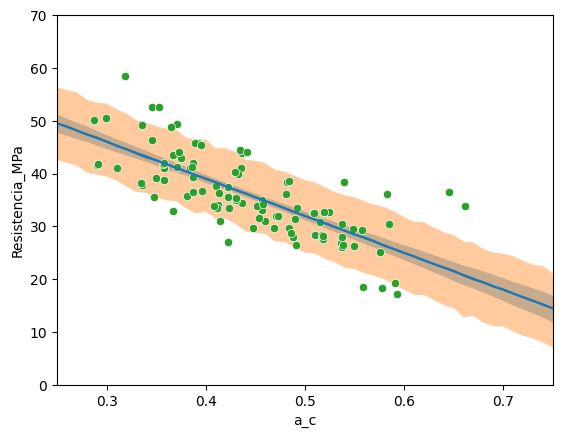

In [17]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Vean que ahora se ve mucho más claro qué me dice el modelo. Por ejemplo, se ve visualmente cuánto cae la resistencia a medida que aumenta la proporción de agua en la mezcla. También se puede ver la incertidumbre en el valor medio (sombra azul), y la dispersión de resultados de una muestra en particular (sombra naranja).

Efectivamente no hice más que ajustar una recta, pero incluyendo incertidumbres.

Luego, podremos discutir si el ajuste es bueno o no (por ejemplo, pareciera que subestimo los datos de las puntas y tiendo a sobreestimar en valores "medios" de agua-cemento.

### Diagnóstico del Modelo 1

Ya con nuestro primer modelo de base, tenemos distintas herramientas para visualizar cómo ajusta y plantear eventuales opciones de mejora. Una de estas herramientas ya la vimos, al graficar qué predice la función (con sus intervalos de confianza) en función de sus variables predictoras. Al incluir el scatterplot de los datos ahí, se puede ver si se parece a los datos.

#### Verificación de la posterior predictiva

Otra forma de ver el ajuste de un modelo es analizar si el mismo es capaz de "reproducir" los datos. Es decir, si los datos medidos podrían haber sido una simulación de mi modelo o no.

Para ello, lo primero que hay que hacer es generar "réplicas de mi dataset". Si yo tenía 103 ensayos de hormigón, para cada simulación de los parámetros (Chain, Draw) haré 103 simulaciones de resistencias. Termino entonces con "miles de datasets" de igual origen, para comparar.

Esa réplica se genera utilizando la función [.predict()](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict) de `Bambi`. Luego, lo que haremos es comparar el histograma de mis datos (*en negro*) contra los histogramas de mis réplicas (*en azul*) y su promedio (La posterior predictiva, *en naranja*).

Si mi modelo se asemeja a los datos, esperaría entonces que la curva negra caiga dentro de las curvas azules, y se parezca mucho a la curva naranja. Cualquier desvío puede implicar que hay algo que no estoy captando en mi modelo. Este gráfico lo genero con la función [plot_ppc()](https://python.arviz.org/en/latest/api/generated/arviz.plot_ppc.html) de `ArviZ`.

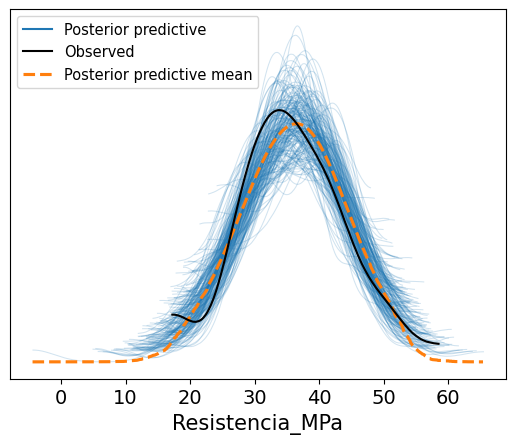

In [18]:
# Genero réplicas de mi dataset
model_1.predict(results_1,kind='response')

# Evaluación de la posterior predictiva
az.plot_ppc(results_1,num_pp_samples = 200)
plt.show()

Otra forma de comparar estas curvas es a través de un qq-plot, en el cual se comparan los cuántiles de los datasets entre sí. La línea a 45 grados implicaría que los histogramas son iguales. Diferencias respecto de ella implica ciertas diferencias en las propiedades de las curvas de probabilidad:

- Si la recta está corrida de la recta a 45 grados (traslación): Diferencia en el valor medio
- Si la recta tiene una pendiente distinta (inclinación): Diferencia en el desvío estandar
- Si la línea negra adquiere forma curva/parabólico: Diferencia en la asimetría de las distribuciones
- Si la línea negra ajusta bien el centro pero se desvío en cuantiles muy chicos o muy grandes (forma de S, por ejemplo): Diferencia en las colas de la distribución/kurtosis.

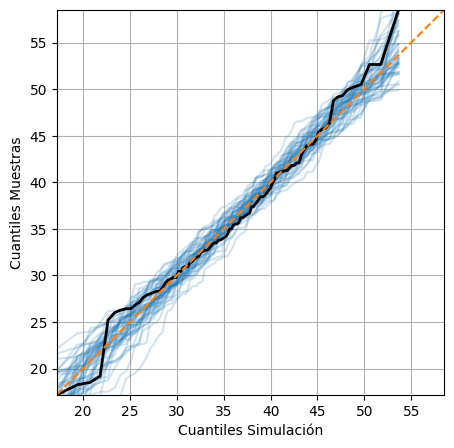

In [19]:
# QQ-PLOT
plot_qqplot(results_1,'Resistencia_MPa',50)
plt.show()

Por ahora, todo se ve bastante bien.

#### Análisis de residuos

Lo siguiente es ver si las hipótesis del modelo de regresión normal se cumplen en mis datos. Para ello se hace un análisis de residuos. Los residuos ("los errores", la diferencia entre el valor medio estimado y el dato) debieran seguir, en un modelo normal, una distribución $N(0,\sigma)$.

Esto podemos verificarlo calculando los errores de mi modelo, y graficando tanto su histograma como un qq-plot (hecho contra la distribución normal ideal).

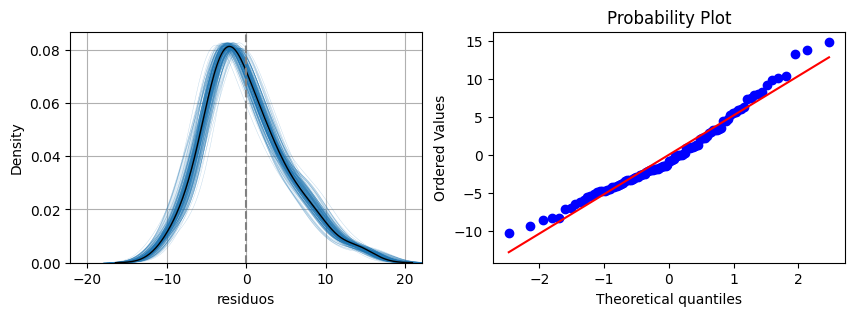

In [63]:
fig, ax = plot_residuos_1(df_horm,results_1,'Resistencia_MPa',num_pp_samples=200)
plt.show()

Notarán cierta curvatura en el qq-plot, indicando alguna asimetría en los residuos (que se pueden ver también en el gráfico de la izquierda).

El hecho de que los errores sean $e \sim N(0,\sigma)$ también implica que los errores son independientes. Por lo tanto, su magnitud tiene que ser constante no importa cuál sea el valor estimado de $Y$ (resistencia del hormigón). Además tienen que estar centrados en cero.

Es decir, los errores tienen que verse como una banda centrada en 0 de ancho constante para todos los valores de resistencia predichos, y ser independientes. Esto lo podemos ver mediante un scatterplot de residuos y calculando su autocorrelación.

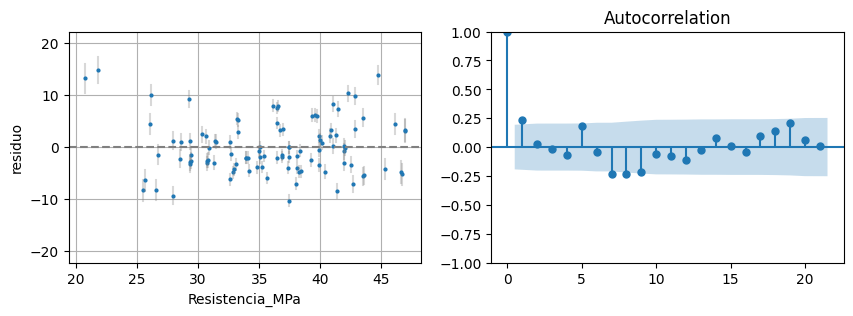

In [76]:
fig, ax = plot_residuos_2(df_horm,results_1,y='Resistencia_MPa')
plt.show()

A veces, sirve hacer ese mismo análisis pero graficando contra una de las variables explicativas. En este caso, puedo hacer el scatterplot contra la relación agua-material cementicio.

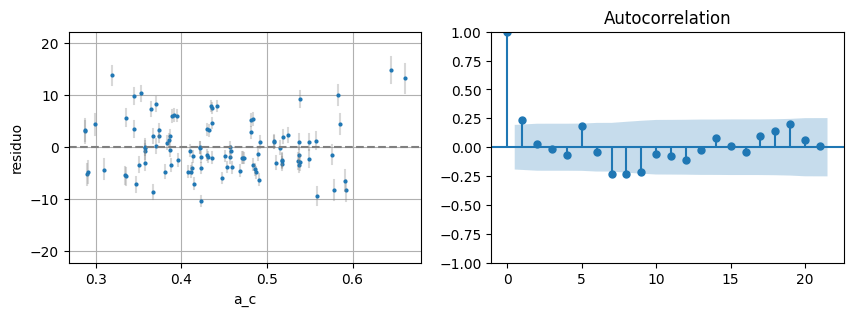

In [77]:
fig, ax = plot_residuos_2(df_horm,results_1,y='Resistencia_MPa',x='a_c')
plt.show()

Acá se ve un poco que los residuos, en función de `a_c` muestran cierta curvatura. Eso implicaría que tal vez una recta no es la mejor forma de modelar su influencia, porque los residuos no me quedaron centrados en 0 para todo valor.

### Modelos potencialmente mejores

Con lo anterior, se les pueden plantear a ustedes ideas para mejorar la forma del modelo con tal de ajustar los datos. A continuación, planteamos una serie de modelos que creemos podrían llegar a funcionar mejor que el lineal.

#### Modelo 2: Hipérbola + error

Este proceso que aplicamos recién podemos usarlo para prácticamente cualquier otro modelo de inferencia. De aquí en más vamos a ir planteando otros modelos simplemente para mostrar distintas variantes que pueden aparecer a la hora de definir el modelo. ¡Todo lo demás es igual!

Uno podía ver los datos de arriba y pensar que la mejor forma de ajustar los datos es con una hipérbola:

$$y = \frac{1}{A\cdot a/c} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\frac{1}{\mu} = A\cdot a/c$$

**Noten que la ecuación está definida para la inversa del valor medio, y que no tiene ordenada al origen**. Luego, definimos distribuciones a priori para los parámetros $A$ y $\sigma$

$$p(A) \sim Exponential(1)$$
$$p(\sigma) \sim Exponential(1)$$

Para cargarlo en `Bambi` debo tener únicamente el cuidado de aclarar el `link='inverse', ya que la ecuación se definió para la inversa del valor medio. Por otro lado, para decir no hay ordenada al origen (no hay "Intercept") lo dejo explicitado con un $0$ en la ecuación

**Nota**: En este caso se definieron a mano las distribuciones a priori porque el link utilizado no es el default para la distribución normal.

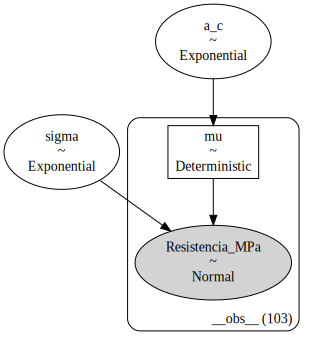

In [25]:
# creamos un modelo hiperbólico (con error absoluto)
prioris = {'a_c':bmb.Prior('Exponential',lam=1),'sigma':bmb.Prior('Exponential',lam=1)}

model_2 = bmb.Model('Resistencia_MPa ~ 0 + a_c', data=df_horm,link='inverse',priors=prioris)
model_2.build()

# visualizacion
model_2.graph()

Puedo ver las prioris que adopté:

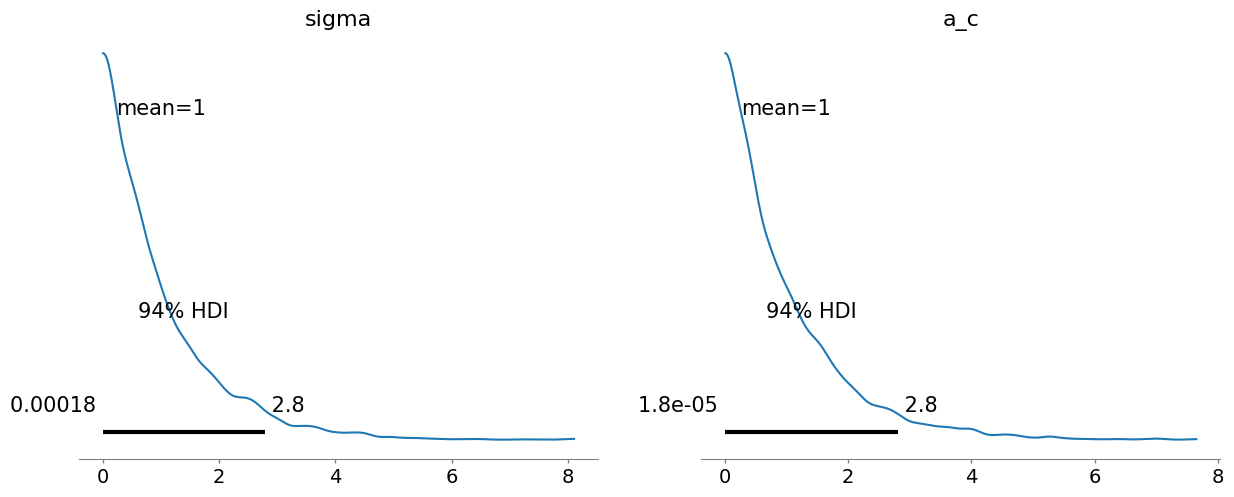

In [26]:
# ver distribuciones a priori
model_2.plot_priors()
plt.show()

Hacer la inferencia y chequear la convergencia de las cadenas:

Output()

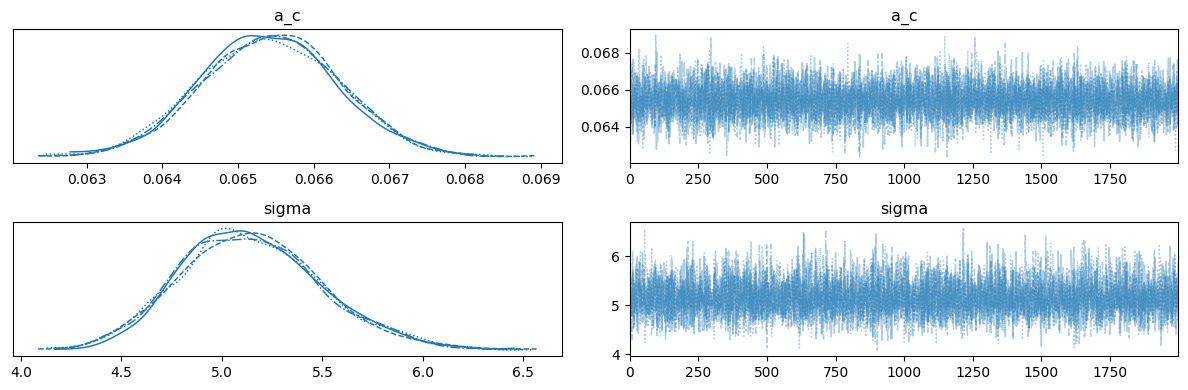

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_c    0.065  0.001   0.064    0.067      0.000    0.000    8822.0    5938.0   
sigma  5.147  0.354   4.463    5.796      0.004    0.004    7743.0    5760.0   

       r_hat  
a_c      1.0  
sigma    1.0

In [27]:
# Realizar la inferencia
results_2 = model_2.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_2)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_2)

Ver la distribución posterior de los parámetros:

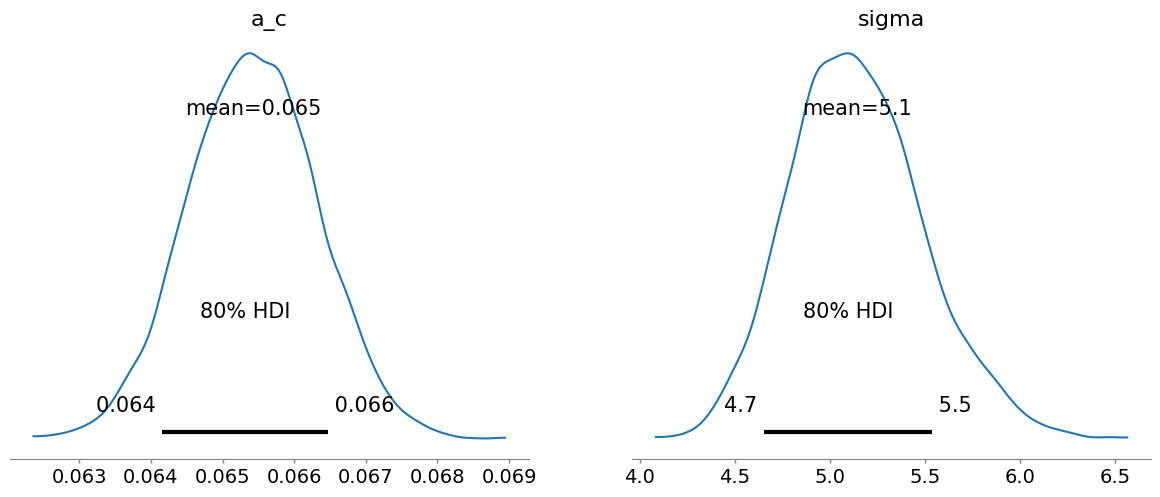

In [28]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_2,hdi_prob=0.8)
plt.show()

Y visualizar el ajuste de la hipérbola con los intervalos de confianza. ¡Todo es exactamente igual que antes!

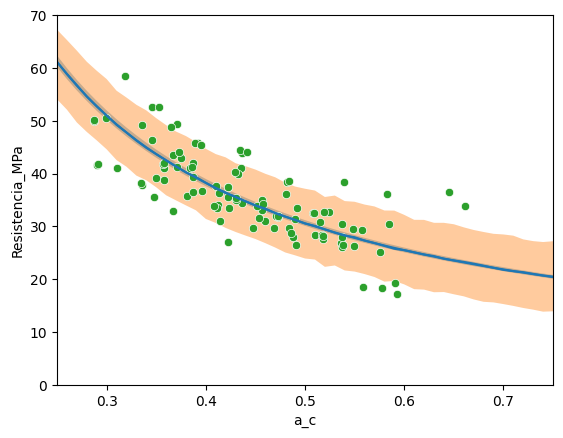

In [29]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

#### Modelo 3: Parábola + error

También podríamos probar de ajustar una parábola a los datos:

$$y = A + B\cdot a/c + C\cdot {a/c}^{2} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B\cdot a/c + C\cdot {a/c}^{2}$$

Con las distribuciones a priori de los parámetros definidas automáticamente por `Bambi`:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(C) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

Para cargarlo en `Bambi`, lo más importante es saber que si algo se escribe entre llaves `{ }`, entonces eso lo considera una "cuenta matemática determinística". Por ejemplo, si quiero que algo depende de $X^{2}$, siendo $X$ una columna de mi dataframe, escribiría `{X**2}`. Con esto, `Bambi` sabe automáticamente que debe tomar la variable `X` y llevarlo al cuadrado.

Esto es mucho mejor que crear una columna en mi dataset con $X^{2}$ porque a fin de cuentas mi predictor es $X$, el cuadrado simplemente indica cómo mi problema se relaciona con $X$. No son dos predictores distintos.

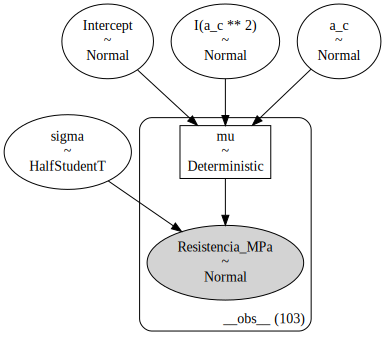

In [30]:
# creamos un modelo parabolico (con error absoluto)
model_3 = bmb.Model('Resistencia_MPa ~ a_c + {a_c**2}', data=df_horm)
model_3.build()

# visualizacion
model_3.graph()

Después, todo lo demás sigue igual...

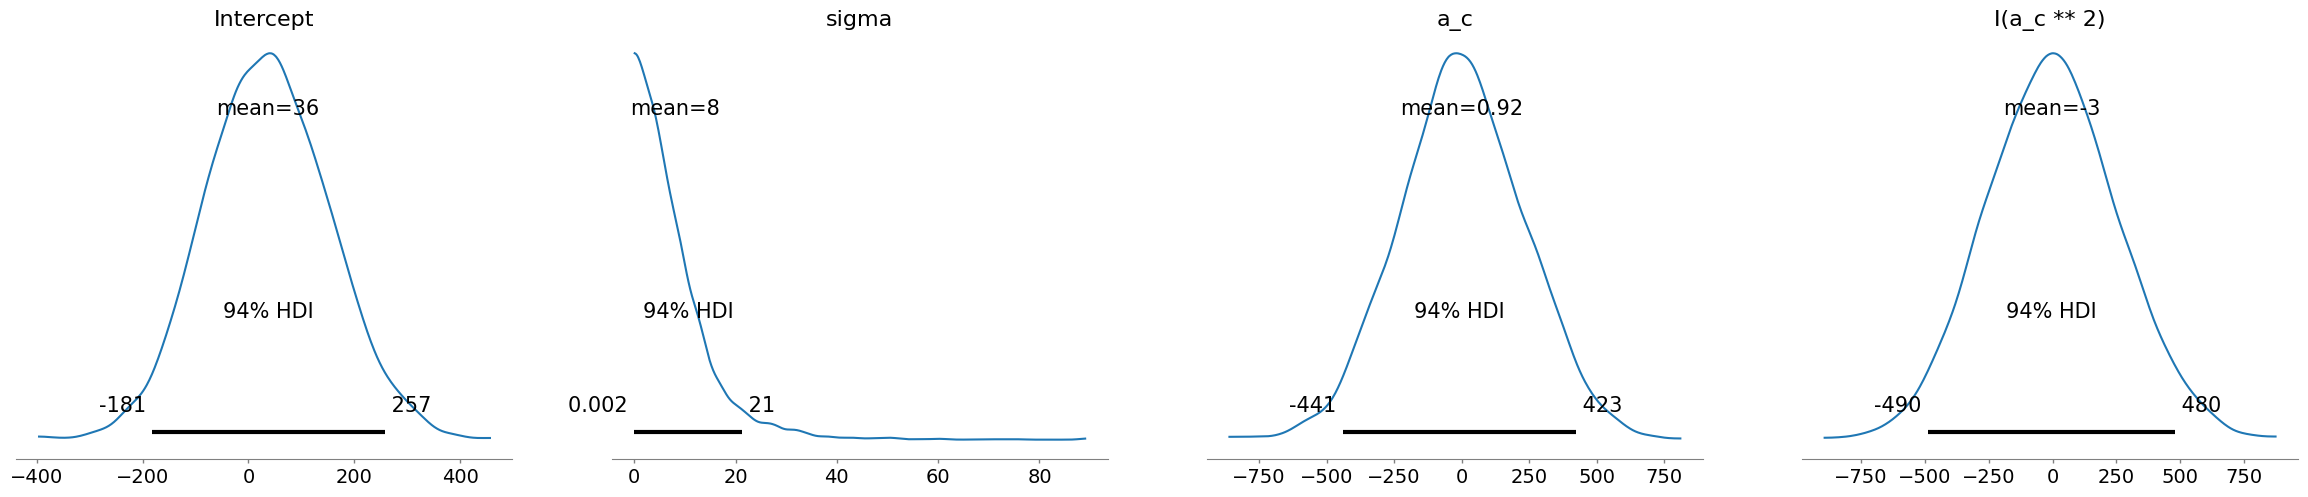

In [31]:
# ver distribuciones a priori
model_3.plot_priors()
plt.show()

Output()

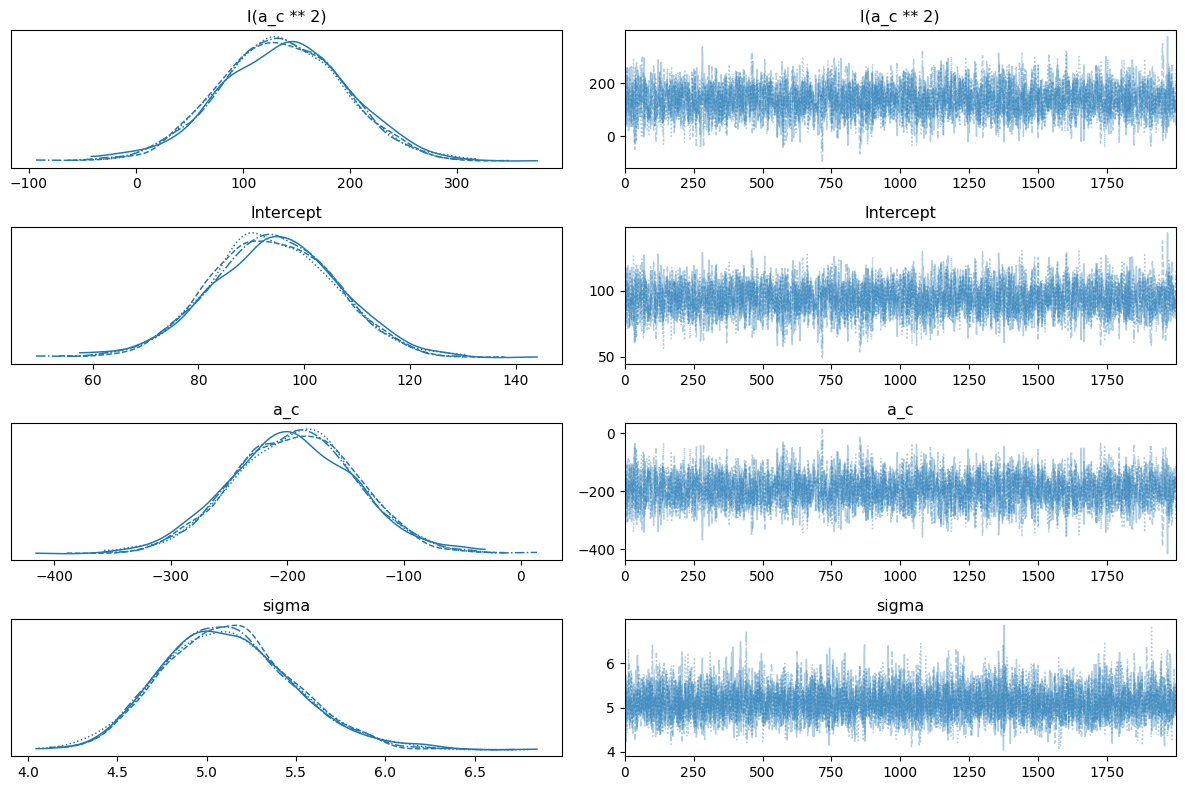

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I(a_c ** 2)  136.452  58.486   30.469  248.777      1.031    0.758    3222.0   
Intercept     94.081  11.805   73.071  117.109      0.204    0.147    3365.0   
a_c         -193.702  53.122 -295.593  -96.531      0.930    0.681    3267.0   
sigma          5.117   0.364    4.466    5.813      0.005    0.005    6228.0   

             ess_tail  r_hat  
I(a_c ** 2)    3693.0    1.0  
Intercept      3721.0    1.0  
a_c            3539.0    1.0  
sigma          4440.0    1.0

In [32]:
# Realizar la inferencia
results_3 = model_3.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_3)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_3)

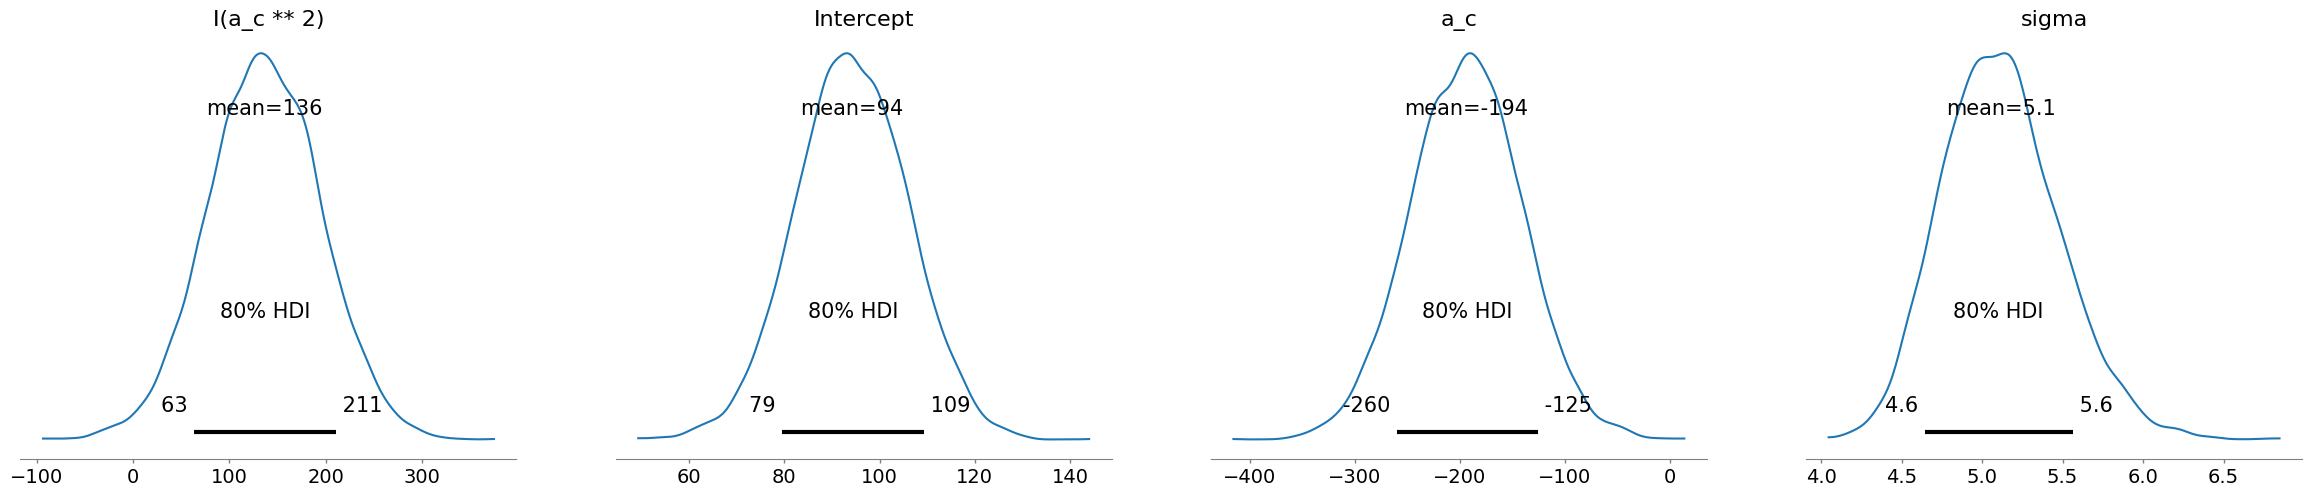

In [33]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_3,hdi_prob=0.8)
plt.show()

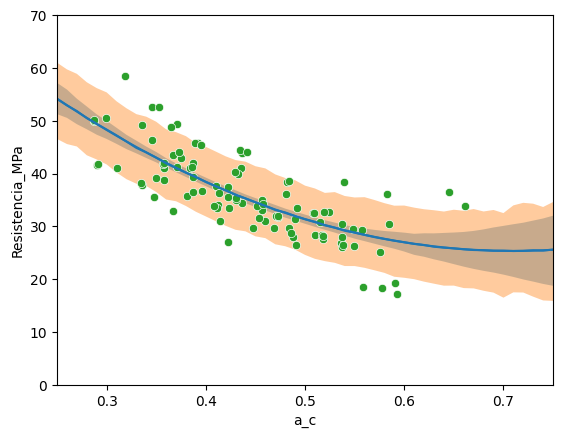

In [34]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

#### Modelo 4: Ley de Abrams (modelo lognormal)

Por último, vamos a ver cómo cargar un modelo lognormal. Como excusa, veremos la Ley de Abrams (no significa que el modelo de Abrams necesariamente sea lognormal)

Por empezar, recordemos que una variable $Y$ es lognormal si su logaritmo $Z=\log Y$ es normal. Entonces, si tratamos al modelo normal como uno de "valor medio más un error", como venimos haciendo:

$$Z = \log Y = \mu_{z} + error$$

$$error \sim Normal(0,\sigma)$$

Entonces el modelo para la variable $Y$ original me queda:

$$e^{Z} = Y = e^{\mu_{z}} \cdot e^{error}$$

¡Es un producto! En particular, un producto entre la mediana de $Y$ y un término de error que sigue una distribución lognormal de mediana igual a 1 y coeficiente de variación $\sigma$.

**En resumen**: Un modelo lognormal es un modelo donde se ajusta una curva para la mediana (en realidad, el valor medio del logaritmo), y el error se propaga como un error *relativo* definido por el parámetro $\sigma$ (el desvío estandar del logaritmo).

Aplicado a la Ley de Abrams, tenemos lo siguiente. Primero, la ecuación para la **mediana** es, según Abrams:

$$\bar y = \frac{c_{1}}{{c_{2}}^{a/c}}$$

El modelo que vamos a adoptar es de errores relativos (lognormal), por lo tanto:

$$y = \frac{c_{1}}{{c_{2}}^{a/c}}\cdot Error$$

donde $Error\sim LN(0,\sigma)$. Tomando el logaritmo, me queda:

$$z = \log c_{1} + \left(-\log c_{2}\right) \cdot a/c + error$$

donde $error \sim N(0,\sigma)$ es el error absoluto, normal, en el logaritmo. Es decir, ¡si tomo el logaritmo a los datos me queda un modelo normal típico como venimos trabajando!

**Resumen**: Por lo tanto, el modelo que estoy ajustando es una recta como venimos haciendo siempre, ¡pero para el logaritmo de las resistencias!

$$\log Y \sim N(\mu,\sigma)$$

$$\mu = A + B\cdot a/c$$

con prioris:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

**Nota**: $A=\log c_{1}$, $B = -\log c_{2}$

##### Construcción

La construcción en `Bambi` de este problema es directa: simplemente aclaro que lo que estoy ajustando es el logaritmo de la columna de Resistencias: `log(Resistencia_MPa)`. El valor medio del logaritmo sigue una recta, por la derivación que hicimos anteriormente.

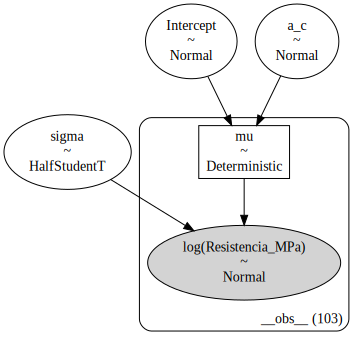

In [35]:
# creamos un modelo de ley de abrams (errores relativos)
model_4 = bmb.Model('log(Resistencia_MPa) ~ a_c', data=df_horm)
model_4.build()

# visualizacion
model_4.graph()

Una vez que llegué acá, es todo lo mismo de antes:

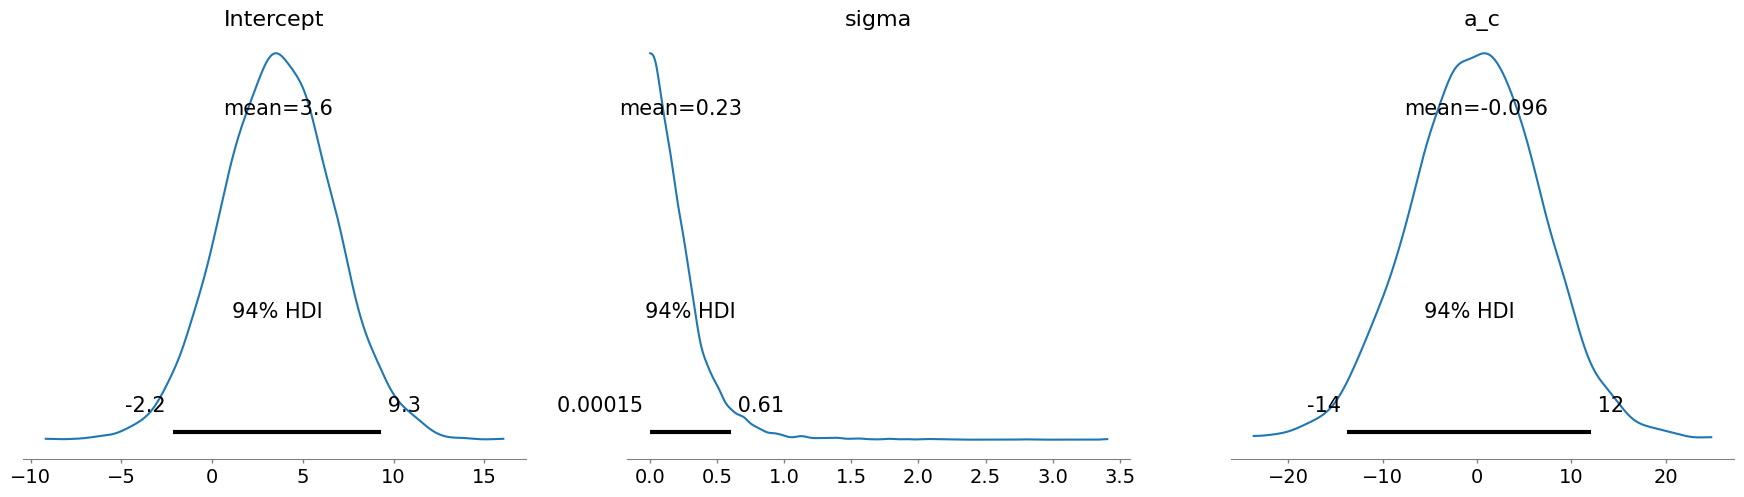

In [36]:
# ver distribuciones a priori
model_4.plot_priors()
plt.show()

Output()

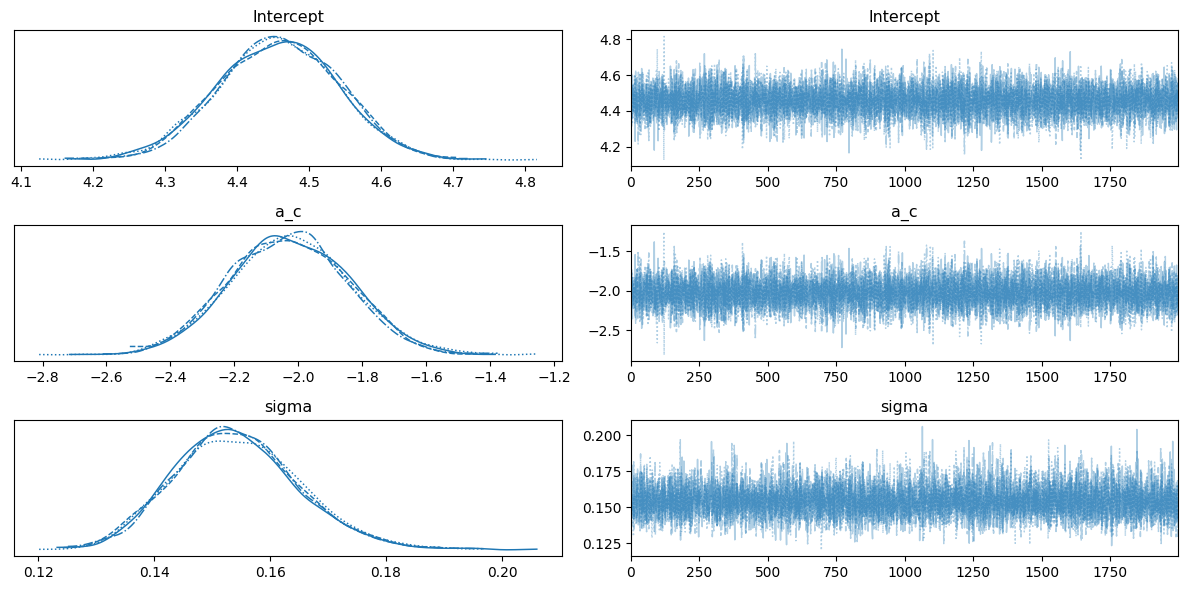

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.457  0.083   4.305    4.613      0.001    0.001   12001.0   
a_c       -2.028  0.186  -2.379   -1.691      0.002    0.002   11832.0   
sigma      0.154  0.011   0.133    0.174      0.000    0.000   12726.0   

           ess_tail  r_hat  
Intercept    5627.0    1.0  
a_c          6075.0    1.0  
sigma        6020.0    1.0

In [37]:
# Realizar la inferencia
results_4 = model_4.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_4)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_4)

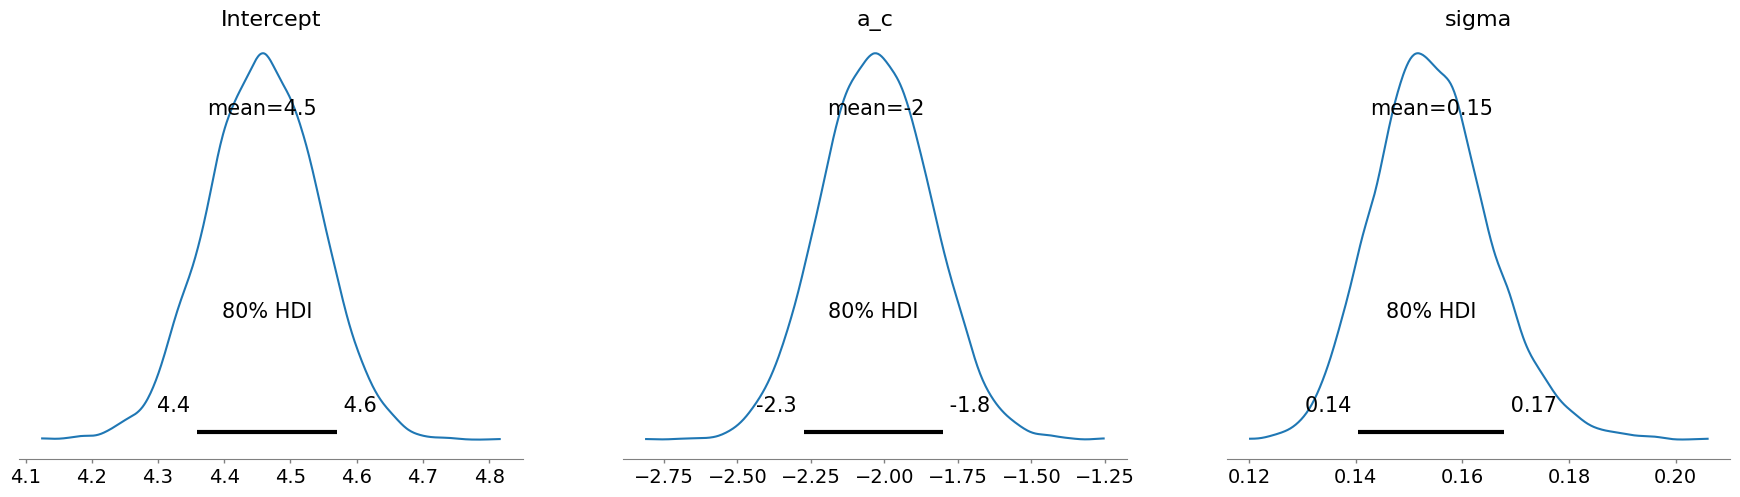

In [38]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_4,hdi_prob=0.8)
plt.show()

El tema aparece a la hora de visualizar la ecuación. Como yo ajuste el logaritmo de la resistencia, el modelo está hecho para predecir logaritmos.

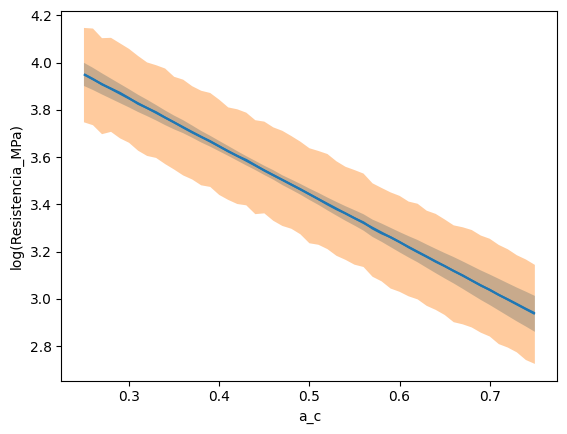

In [39]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)
plt.show()

##### Transformación

Necesitamos, entonces, volver a la escala original en el gráfico de visualización del modelo. Para eso podemos usar la opción `transforms` dentro de la función `interpret.plot_predictions()`.

En este caso, lo que queremos hacer es exponenciar a los logaritmos de la resistencia predichos. Luego, manualmente le cambiamos el nombre del eje $y$ al gráfico.

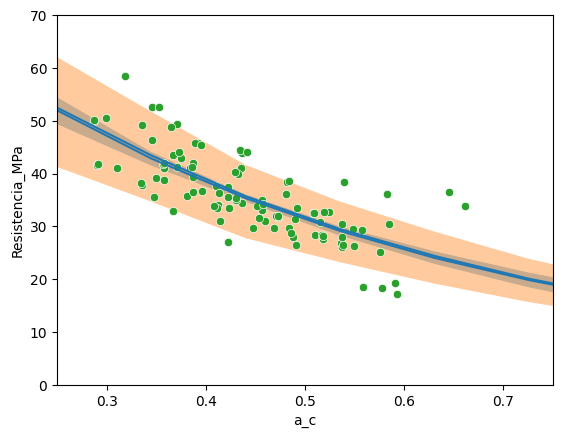

In [40]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=True,prob=0.8,ax=ax)
plt.ylabel('Resistencia_MPa')

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Noten como la sombra naranja (la dispersión de los resultados) disminuye a medida que disminuye el valor medio predicho. Esto es porque un modelo lognormal, es un modelo de errores relativos.

**Nota**: Que la dispersión se reduzca no parece justificarse por los datos. ¿Cómo podrían hacer para utilizar la ley de Abrams con un modelo de errores absolutos?

#### Modelo 5: Ley de Abrams (modelo normal)

El modelo de Abrams es el de una recta logarítmica, pero yo puedo luego asignarle el modelo de error que yo quiera. Antes, propusismos un modelo de error lognormal (errores relativos) y por eso ajustamos "logaritmos de la resistencia".

Otra opción es decir que efectivamente la resistencia al hormigón sigue la recta logarítmica de Abrams, pero los errores son normales. Para ello, ¡ajusto un modelo normal! Lo que cambia es la ecuación para el valor medio, que sigue la ley de Abrams.

$$Y \sim N(\mu,\sigma)$$

$$\log \mu = A + B\cdot a/c$$

con prioris:

$$p(A) \sim N(3.6,2.8)$$
$$p(B) \sim N(0,7)$$
$$p(\sigma) \sim Exp(1)$$

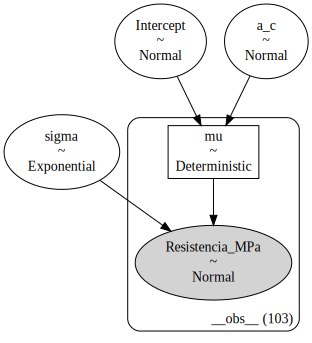

In [41]:
# creamos un modelo de ley de abrams (errores absolutos)
prioris = {'Intercept':bmb.Prior('Normal',mu=3.6,sigma=2.8),
           'a_c':bmb.Prior('Normal',mu=0,sigma=7),
           'sigma':bmb.Prior('Exponential',lam=1)}

model_5 = bmb.Model('Resistencia_MPa ~ a_c', link='log',data=df_horm,priors=prioris)
model_5.build()

# visualizacion
model_5.graph()

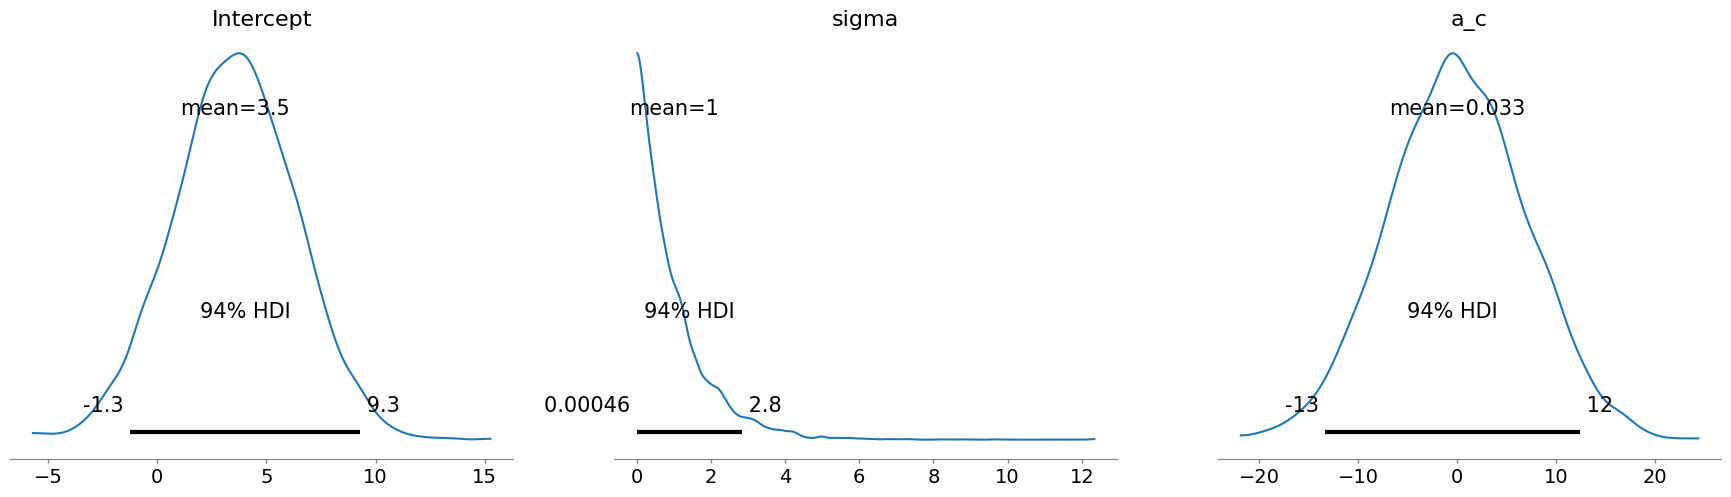

In [42]:
# ver distribuciones a priori
model_5.plot_priors()
plt.show()

Output()

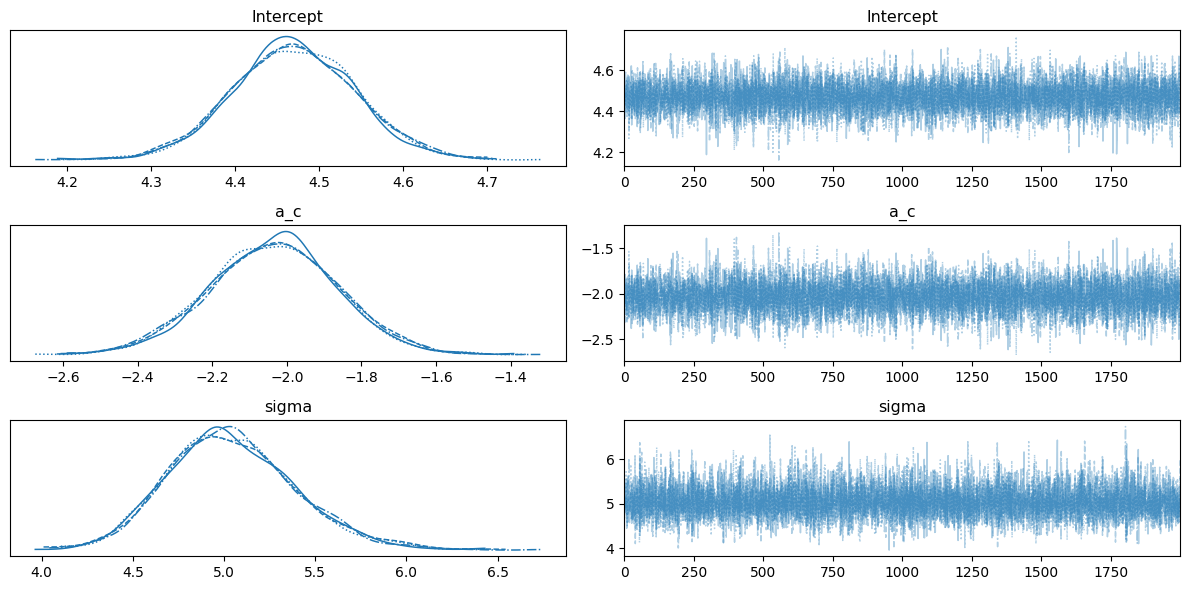

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.470  0.073   4.335    4.611      0.001    0.001   10288.0   
a_c       -2.036  0.173  -2.370   -1.720      0.002    0.002    9486.0   
sigma      5.043  0.351   4.433    5.733      0.003    0.004   11340.0   

           ess_tail  r_hat  
Intercept    6309.0    1.0  
a_c          6362.0    1.0  
sigma        5851.0    1.0

In [43]:
# Realizar la inferencia
results_5 = model_5.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_5)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_5)

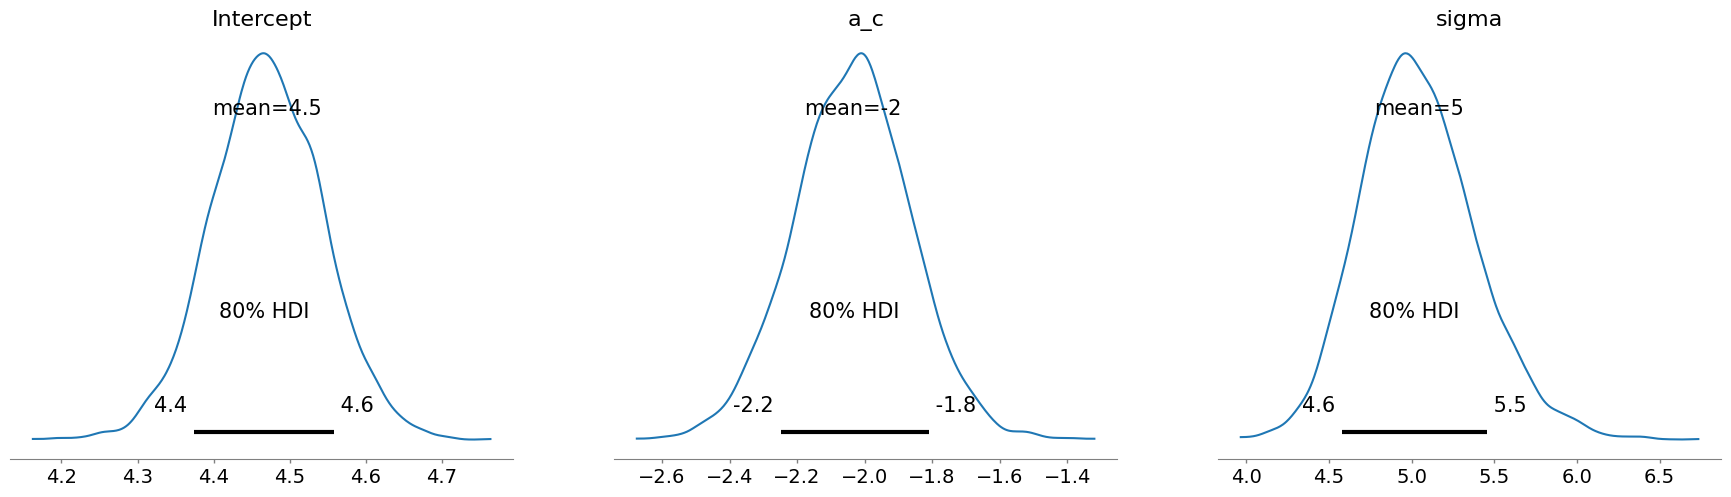

In [44]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_5,hdi_prob=0.8)
plt.show()

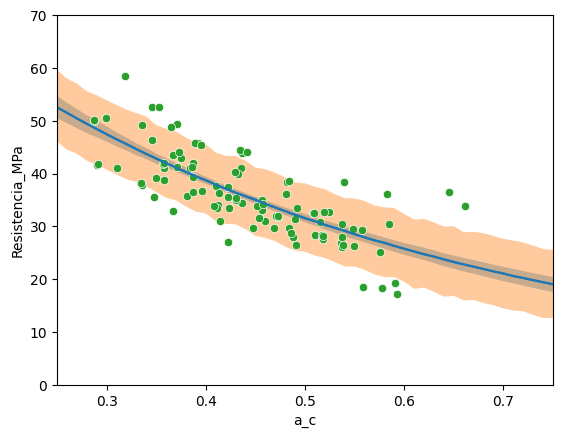

In [45]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_5,results_5,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_5,results_5,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

### Selección de modelos

Habiendo hecho todo esto, ahora tenemos 5 modelos posibles para la relación entre la relación agua-material cementecio y la resistencia. Estaría bueno ver cuál es la que mejor ajusta a los datos disponibles.

Una opción, que debieran ir haciendo, es ver los gráficos de cómo funcionan los modelos. Ahí podrían ver que el modelo 4 (ley de Abrams con errores relativos) justamente no capta muy bien la dispersión en los resultados. Por eso se probó la ley de Abrams con errores absolutos en el modelo 5. También verán que cualquier modelo curvo parece ajustar mejor que la recta al valor medio.

Para ser más "precisos", vamos a cuantificar qué modelo podría ser mejor a partir de su capacidad predictiva (más bien, cuál es la probabilidad de ver los datos).

Hoy nos vamos a ocupar de una forma de estimarla que es el Leave-One-Out Cross Validation. La idea es la siguiente, si yo ajusto un modelo para todos los datos salvo uno, que tan bien puedo predicir ese dato que deje afuera (o, qué tan probable sería verlo con mi modelo?) Y si me hago esa pregunta para todos los datos de a uno por vez, tendría una buena medida de qué tan capaz es mi modelo de predecir datos que no vio.

El problema es que ajustar el modelo N-1 veces es muy costoso, pero existen métodos para estimar el resultado sin tener que volver a pasar por las cadenas de Markov. Esto es lo que se conoce como PSISLOO (Pareto Smoothed Importance Sampling Leave One Out Cross Validation).

Por suerte, correrlo se vuelve una línea de código!

#### Capacidad predictiva (PSIS-LOO CV)

Lo primero que vamos a hacer es agregar a nuestros Inference Data de los modelos, los valores de la log-verosimilitud. Esto lo podemos hacer con la función [compute_log_likelihood()](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.compute_log_likelihood).

In [46]:
# Calculo la logverosimilitud de cada modelo
model_1.compute_log_likelihood(results_1)
model_2.compute_log_likelihood(results_2)
model_3.compute_log_likelihood(results_3)
model_4.compute_log_likelihood(results_4)
model_5.compute_log_likelihood(results_5)

Verán que eso agrega un nuevo sector en los Inference Data.

In [47]:
results_1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

**NOTA**: El modelo 4 era lognormal, y lo obtuvimos modelando el logaritmo de los datos. Por lo tanto, tanto las simulaciones como las log-verosimilitudes están hechas para el logartimo.

Es *muy importante* transformar todo esto si quiero que las cosas salgan bien. Para ello, usamos el siguiente código para hacer el cambio de variables. Vamos a generar un Inference Data "transformado" con otro nombre, que es el que vamos a usar para la comparación.

In [48]:
# El modelo 4 es lognormal (ajusta log(Resistencia_MPa)), necesito transformar
results_4_T = results_4.map(lambda x: np.exp(x),groups='observed_vars',inplace=False)
results_4_T.rename({'log(Resistencia_MPa)':'Resistencia_MPa'},inplace=True)

# Eso incluye transformar log-verosimilutdes
results_4_T.map(lambda x: x-np.log(results_4_T.observed_data['Resistencia_MPa']),
                groups='log_likelihood',inplace=True)

Hecho esto, se arma un diccionario con los Inference Data de cada modelo, y la estimación de la capacidad predictiva (in-sample y out-of-sample) se hace con la función de `ArviZ` [az.compare()](https://python.arviz.org/en/latest/api/generated/arviz.compare.html). La misma devuelve una tabla resumen, ordenada de mejor a peor capacidad predictiva.

In [49]:
# Genero un diccionario
model_dict = {'recta':results_1,'hipérbola':results_2,'parábola':results_3,
'Abrams (lognormal)':results_4_T,'Abrams (normal)':results_5}

# Calculo LOO-CV
model_comp = az.compare(model_dict)

# Tabla resumen
model_comp

rank    elpd_loo     p_loo  elpd_diff    weight        se  \
Abrams (normal)        0 -316.300781  3.444999   0.000000  0.673077  7.417780   
parábola               1 -316.841185  5.372815   0.540404  0.000000  6.984192   
hipérbola              2 -317.735637  2.025267   1.434856  0.326923  7.173770   
recta                  3 -318.788212  4.029404   2.487431  0.000000  7.864010   
Abrams (lognormal)     4 -322.281421  4.716702   5.980640  0.000000  8.834559   

                         dse  warning scale  
Abrams (normal)     0.000000    False   log  
parábola            1.480861    False   log  
hipérbola           2.918837    False   log  
recta               1.762224    False   log  
Abrams (lognormal)  3.805701    False   log

Veamos que significan las columnas de interés para nosotros:

- elpd_loo: el resultado de la "log-predictive density" estimada por PSIS-LOO-CV *out-of-sample*. Es decir, la capacidad predictiva.
- elpd_diff: Simplemente la diferencia entre entre capacidades predictivas respecto del mejor (el primero de la lista). Existen criterios para decir cuándo una diferencia es importante (por ejemplo, hay trabajos que indican que para un `elpd_diff` menor a 4 entonces la diferencia es pequeña entre los modelos)
- weight: da la idea de cómo combinar las distribuciones en una mezcla para mejorar la predicción.
- se: es el error en la estimación del `elpd`, ya que es una aproximación del *out-of-sample*.
- dse: es el error (aproximadamente el desvío estandar) en la estimación del `elpd_diff`.
- warning: indica si la estimación del LOO es buena o no. Si no lo es, habría que pasar a un k-fold cross validation tal vez (no siempre es necesario).

La idea sería la siguiente:
1. Ver si `elpf_diff` es mayor a 4. Si no lo es, la diferencia no es importante (en parte porque no se puede ajustar un modelo normal a las estimaciones).
2. Si lo es, comparar `elpd_diff` contra `dse` (asumiendo que tengo al menos 100 datos). Si este ratio es mayor a 1 (la diferencia es mayor a 1 desvíos estandar), entonces la diferencia es siginificativa (algunos autores acá toman un valor de 2 o de 4 por que la estimación de `dse` es optimista)
2. Caso contrario, no puedo realmente distinguir entre los modelos (hay cierta arbirtrariedad acá, lo importante es informar los valores).

**NOTA**: 1 y 2. son en realidad criterios distintos, pero nuevas recomendaciones las combinan (¡El investigador principal de todo esto está muy activo en redes y tiene un FAQ!). https://users.aalto.fi/~ave/CV-FAQ.html

En nuestra experiencia en el curso y con la cantidad de datos que trabajamos, en general estamos en esta situación donde la diferencia nunca llega a ser significativa. En ese sentido siempre recomendamos agarrar el mejor modelo entre los modelos sencillos (de menor cantidad de parámetros), incorporando también conocimiento del proceso físico (si hay razones para pensar que los datos vienen de una lognormal, y no puedo justificar con los datos un modelo distinto, voy con esa!). Del mismo modo, entre modelos parecidos es habitual elegir el más usado en la bibliografía.

Los mismos resultados los puedo ver en forma gráfica con la función [az.plot_compare()]()

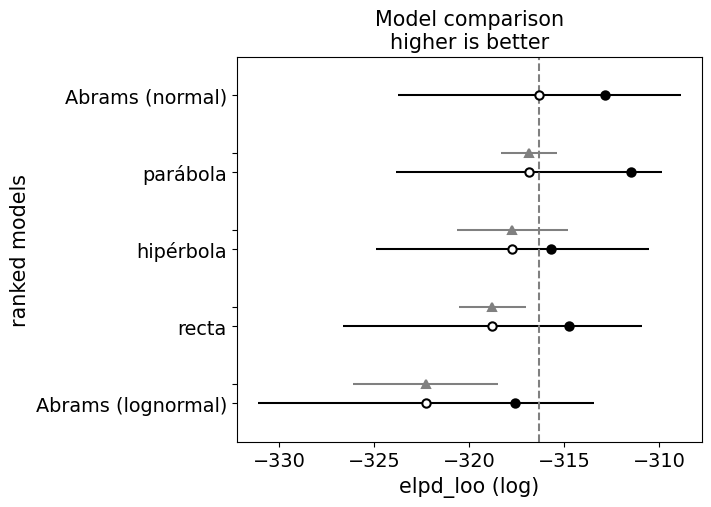

In [50]:
# Resumen grafico
az.plot_compare(model_comp,plot_ic_diff=True,insample_dev=True)
plt.show()

Noten que el punto negro es la capacidad predictiva de los datos vistos, mientras que el blanco la de los datos no vistos. Fijense que la parábola (de 4 parámetros), tiene mayor diferencia entre los datos vistos y no vistos respecto de modelos más sencillos (como la hipérbola, de 2 parámetros).

Vean también que los triangulos muestran la diferencia entre capacidades predictivas con un más menos de 1 desvío estandar, como para ver gráficamente si puedo afirmar que un modelo es mejor que otro.

El resumen para este ejercicio, es que el "mejor modelo" es la ley de Abrams con errores absolutos. No es significativamente mejor que la parábola o la hipérbola (las líneas grises cruzan su capacidad predictiva), pero visto que es el modelo más utilizado en la práctica profesional, es correcto elegirlo.

Mientras tanto, el modelo de recta como el modelo Abrams con errores relativos son significativamente inferiores, según los datos.

NOTA: Obviamente, podría haber modelos mejores que este.

### Diagnóstico del Modelo "Ganador"

Una vez que tengo un "modelo elegido", debiera evaluarlo igual que hice al principio para la recta. Es decir, ver dónde funciona, dónde falla y si se ajusta a los datos (que sea el que "más se ajusta" no me alcanza). Si todo eso da OK, entonces sí lo adopto como modelo y lo uso para contestar mis preguntas.

Abajo dejamos los gráficos corridos para que vean que efectivamente este modelo "me sirve" para lo que quiero hacer.

#### Verificación de la posterior predictiva

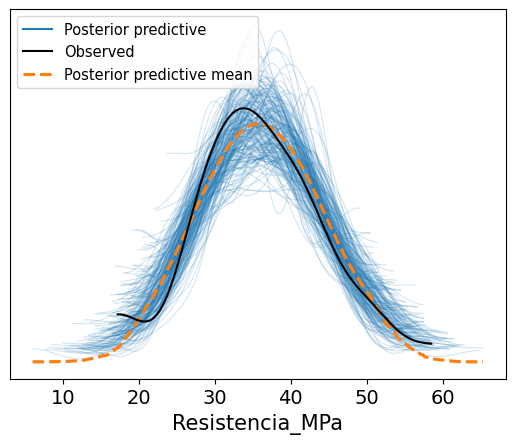

In [51]:
# Genero réplicas de mi dataset
model_5.predict(results_5,kind='response')

# Evaluación de la posterior predictiva
az.plot_ppc(results_5,num_pp_samples = 200)
plt.show()

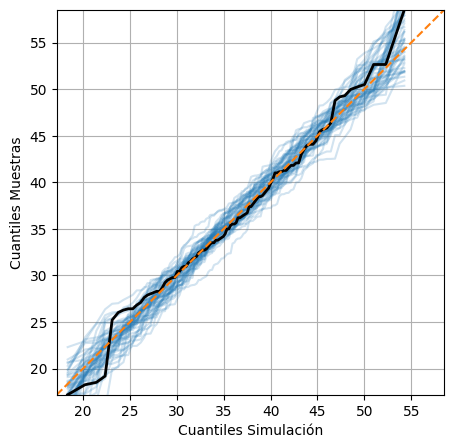

In [52]:
# QQ-PLOT
plot_qqplot(results_5,'Resistencia_MPa',50)
plt.show()

#### Análisis de residuos

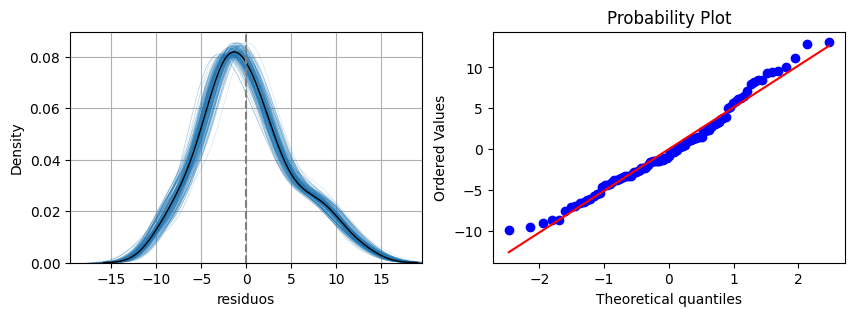

In [68]:
fig, ax = plot_residuos_1(df_horm,results_5,'Resistencia_MPa',num_pp_samples=200)
plt.show()

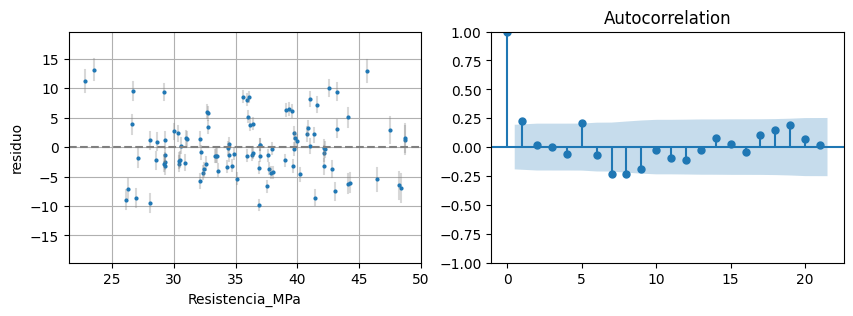

In [78]:
fig, ax = plot_residuos_2(df_horm,results_5,y='Resistencia_MPa')
plt.show()

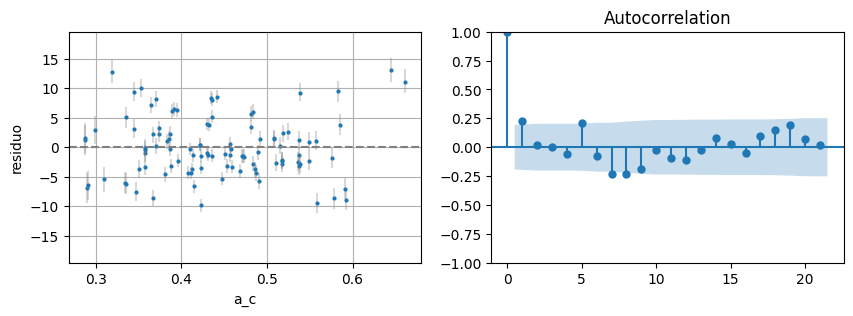

In [79]:
fig, ax = plot_residuos_2(df_horm,results_5,y='Resistencia_MPa',x='a_c')
plt.show()